In [4]:
# -*- coding: utf-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Data Source: https://www.blockchain.com/ko/charts/market-price?timespan=60days
file_path = '../data/market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])

# 기본 정보를 출력합니다.
print(bitcoin_df.shape)
print(bitcoin_df.info())
bitcoin_df.tail()

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


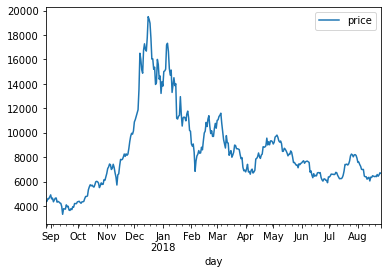

In [6]:
# to_datetime으로 day 피처를 시계열 피처로 변환합니다.
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

# day 데이터 프레임의 index로 설정합니디.
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)

# 일자별 비트코인 시세를 시각화합니다.
bitcoin_df.plot()
plt.show()

In [7]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [8]:
# (AR=2. 차분(경향성)=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.553
Method:                       css-mle   S.D. of innovations            512.415
Date:                Tue, 15 Dec 2020   AIC                           5587.107
Time:                        15:57:59   BIC                           5610.490
Sample:                             1   HQIC                          5596.400
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3404     27.794      0.228      0.820     -48.135      60.816
ar.L1.D.y     -0.3791      1.831     -0.207      0.836      -3.968       3.209
ar.L2.D.y      0.1584      1.193      0.133      0.8

<AxesSubplot:>

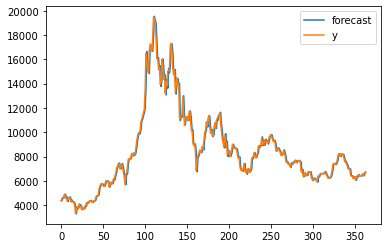

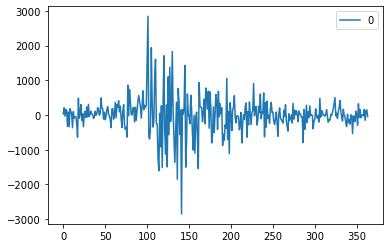

In [9]:
fig = model_fit.plot_predict() # 학습 데이터에 대한 예측 결과입니다. (첫 번째 그래프)
residuals = pd.DataFrame(model_fit.resid) # 전차의 변동을 시각화합니다. (두 번쨰 그래프)
residuals.plot()

In [10]:
# forecast 결과는 순서대로 예측값, stderr, upper bound, lower bound 이다.
forecast_data = model_fit.forecast(steps=5) # 학습 데이터셋으로부터 5일 뒤 예측합니다.
print(forecast_data)

(array([6676.90543762, 6685.02457629, 6690.26166991, 6697.30209282,
       6703.2024426 ]), array([ 512.41529732,  753.50357425,  914.97685301, 1061.45313804,
       1184.439298  ]), array([[5672.58990975, 7681.2209655 ],
       [5208.18470855, 8161.86444404],
       [4896.93999132, 8483.58334849],
       [4616.89217099, 8777.71201466],
       [4381.74407666, 9024.66080855]]))


In [11]:
# 테스트 데이터셋을 불러옵니다.
test_file_path = '../data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31) 
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값입니다.

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

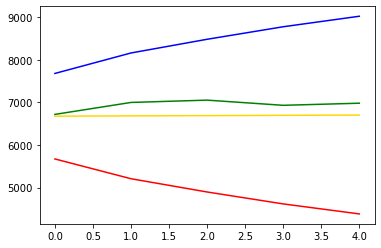

In [12]:
plt.plot(pred_y, color="gold") # 모델이 예측한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예측한 최저 가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예측한 최고 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

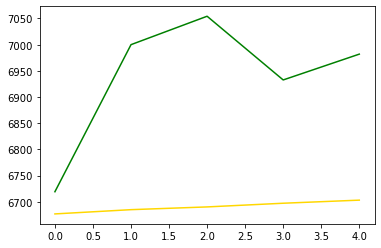

In [13]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [23]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

151.367832019998


In [14]:
from fbprophet import Prophet

In [15]:
# prophet을 사용하기 위해서는 다음과 같이 피처명을 변경해야 합니다: 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
# seasonality_mode 연간 주간 월간 등의 트렌드성을 반영하는 것을 의미하는 파라미터입니다.
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True,
                  daily_seasonality=True,
                  # changepoint_prior_scale 트렌드가 변경되는 문맥을 반영하는 파리미터입니다. 수치가 높을 수록 모델은 과적합과 가까워집니다.
                  changepoint_prior_scale=0.5)
# fit( ) 함수를 통해 모델을 훈련하고 predict( )함수를 사용해 예측을 만들 수 있다.
prophet.fit(bitcoin_df)

In [16]:
# 5일을 내다보며 예측합니다.
# make_future_dataframe() 함수를 이용해 예측값을 넣을 데이터 프레임을 생성합니다. 
# 이때, 인자로 들어가는 periods 값은 향후 몇일 (또는 주,월 등 단위 주기) 을 예측할 것인지를 의미합니다. 
future_data = prophet.make_future_dataframe(periods=5, freq='d')
# 모델을 만들고 나면 새로운 데이터에 대한 예측값은 predict( )로 구할 수 있다.
forecast_data = prophet.predict(future_data)
# tail(5) 하단부분 5개 출력
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6923.647020,6265.425519,7573.962879
366,2018-08-28,7019.400574,6267.545686,7727.266602
367,2018-08-29,7034.842537,6288.354598,7766.122589
368,2018-08-30,7108.190099,6330.732854,7836.587827
369,2018-08-31,7184.990775,6397.070359,7962.497003


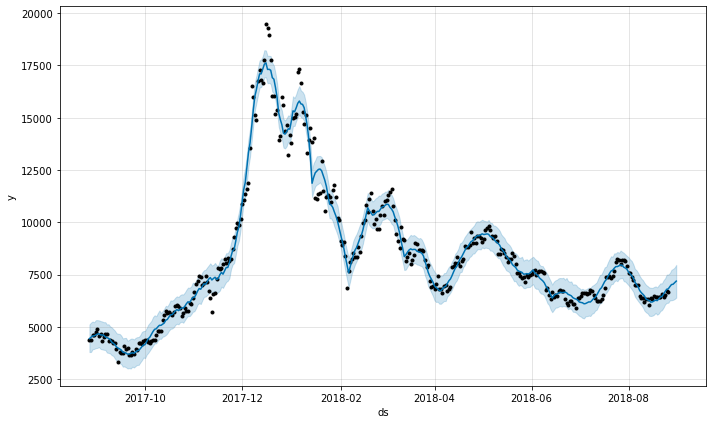

In [17]:
fig1 = prophet.plot(forecast_data)

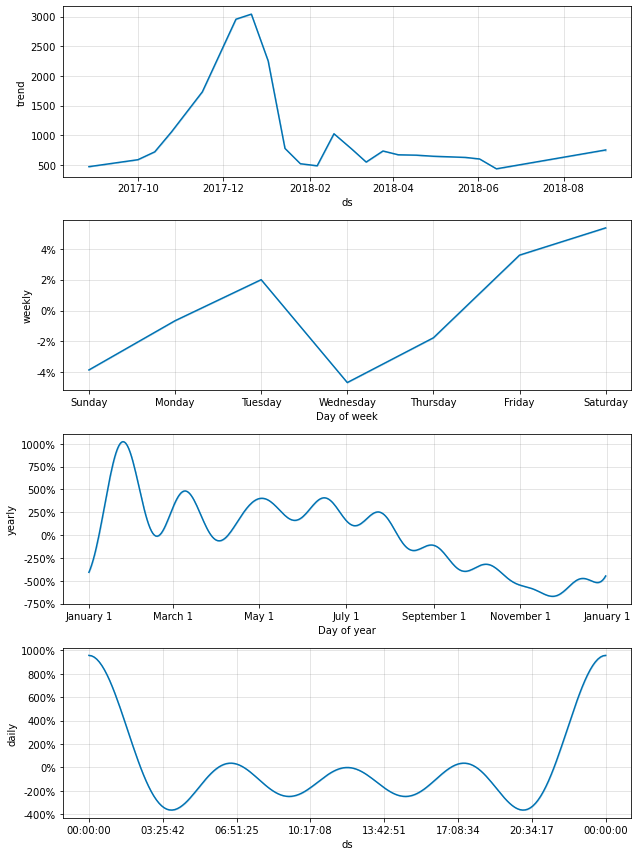

In [18]:
# 트렌드 정보 시각화 그래프 출력 ( seasonality_mode 파라미터를 설정해 놓은 경우에만 시각화가 가능하다)
fig2 = prophet.plot_components(forecast_data)

In [20]:
# Prophet를 활용하여 테스트 데이터셋을 평가해보자
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y = forecast_data.yhat.values[-5:]
# 실제 5일 가격 데이터입니다.
test_y = bitcoin_test_df.y.values
# 마지막 5일 예측 데이터의 최소값입니다.
pred_y_lower = forecast_data.yhat_lower.values[-5:]
# 마지막 5일의 예측 데이터의 최대값입니다.
pred_y_upper = forecast_data.yhat_upper.values[-5:]

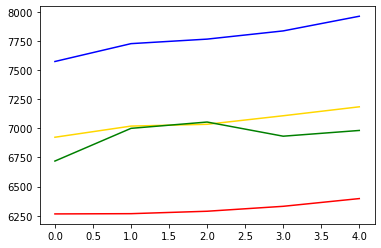

In [22]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최저 가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최고 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

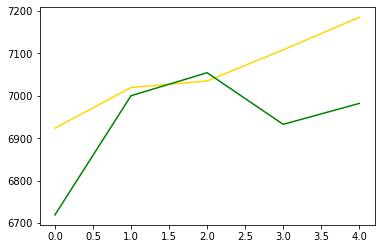

In [24]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [25]:
# MSE : 가장 일반적이고 직관적인 에러 지표. 에러를 제곱하여 평균을 계산하니, 값은 낮을수록 좋다
# RMSE : MSE 에 Root 를 씌운 에러 지표. 값은 낮을수록 좋다.
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

151.367832019998


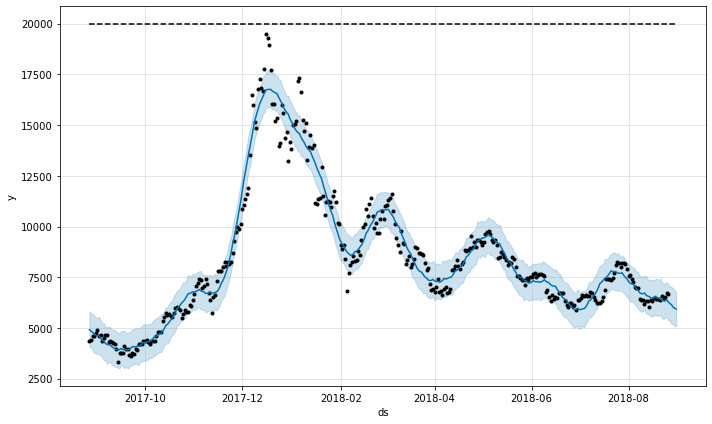

In [26]:
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])

# 상한가를 설정합니다.
bitcoin_df['cap'] = 20000

# 상한가를 적용을 위한 파리미터를 다음과 같이 설정합니다.
prophet = Prophet(seasonality_mode='multiplicative',
                 growth='logistic',
                 yearly_seasonality=True,
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가를 설정합니다.
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

In [27]:
# Prophet를 활용하여 테스트 데이터셋을 평가해보자
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y = forecast_data.yhat.values[-5:]
# 실제 5일 가격 데이터입니다.
test_y = bitcoin_test_df.y.values
# 마지막 5일 예측 데이터의 최소값입니다.
pred_y_lower = forecast_data.yhat_lower.values[-5:]
# 마지막 5일의 예측 데이터의 최대값입니다.
pred_y_upper = forecast_data.yhat_upper.values[-5:]

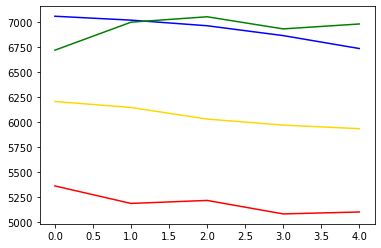

In [28]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최저 가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최고 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [30]:
# 이상치(평균적인 수치에 비해 지나치게 높거나 낮은 수치의 데이터) 제거 기법을 활용
# 18000 이상의 데이터는 이상치라고 판단합니다.
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
# loc	인덱스 기준으로 행 데이터 읽기
bitcoin_df.loc[bitcoin_df['y'] > 18000, 'y'] = None

# prophet 모델을 학습합니다.
prophet = Prophet(seasonality_mode='multiplicative',
                 yearly_seasonality=True,
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일 단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

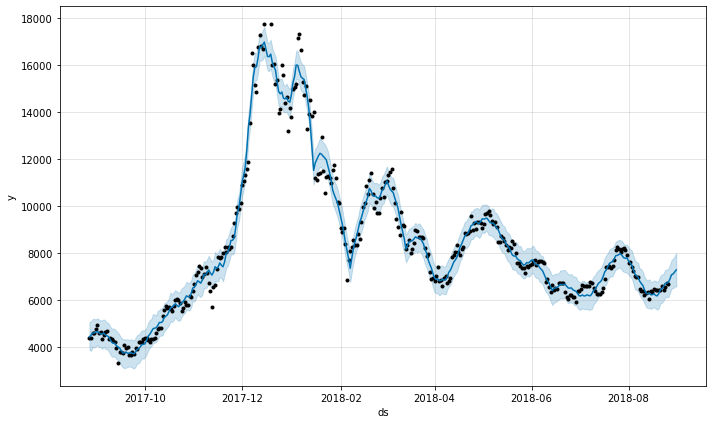

In [31]:
# 예측 결과를 그래프로 출력합니다.
fig = prophet.plot(forecast_data)

902.9644740341969


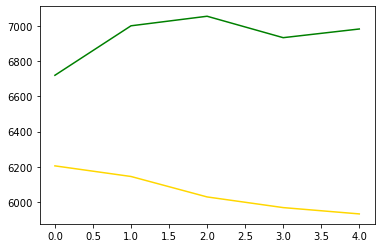

In [32]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

# 테스트 데이터의 RMSE를 출력합니다.
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)